# IMPORTS

In [1]:
import yaml
import firebase_admin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy import stats
import seaborn as sns

import requests
import json

from math import sin, cos, sqrt, atan2, radians


from firebase_admin import credentials
from firebase_admin import firestore

from matplotlib import pyplot

from matplotlib.patches import Polygon
from pandas.plotting import scatter_matrix

# CONNECT TO FIREBASE

In [2]:
filename='/Users/5danalfaro/OAN/credentials/firebase_parameters.json'

In [3]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

# GET VILLAGE AND PRIORITY SURVEYS

In [4]:
col_query = db.collection('Surveys').document('Backup').collection('Answers').where(u'survey_type', u'==', u'2-survey_priority')


In [5]:
col_sur_priority = col_query.stream()

In [6]:
l_sur_priority = []
for doc in col_sur_priority:
    l_sur_priority.append(doc.to_dict())

In [7]:
len(set([a['coords']['longitude']for a in l_sur_priority]))

121

In [8]:
col_query = (db.collection('Surveys').
                    document('Backup').
                        collection('Answers').
                            where(u'survey_type', u'==', u'1-survey_village')
            )

In [9]:
col_sur_village = col_query.stream()

In [10]:
l_sur_village = []
for doc in col_sur_village:
    l_sur_village.append(doc.to_dict())

In [11]:
len(set([a['data']['village_coords'] for a in l_sur_village]))

11

In [12]:
len(l_sur_village)

18

In [13]:
[vil['data']['village_name'] for vil in l_sur_village]

['Bio Sika Kparou ',
 'Kora seko Kparou où Sansi Gah Gourou',
 'Sonkorou',
 'Danon',
 'Sonkorou',
 'Debbo',
 'Gnankpare',
 'Tata Lafiarou ou Djonwouro Kparou ',
 'Danon',
 'Chein Gbérou Kpanin',
 'Gbérou kpanin',
 'Wodora',
 'Bio Sika Kparou ',
 'Alafiarou',
 'Tata Lafiarou ou Djonwouro Kparou ',
 'Debbo',
 'Gnankpare',
 'Chein Gbérou Kpanin']

In [14]:
[vil['data']['village_pop'] for vil in l_sur_village]

['200', 'null', '250', '120', '500', '150', '70', '400', '80', '150', '300']

# PROCESS DATA

## PRIORISATION DATA

In [15]:
df_priority=pd.DataFrame([{'latitude':doc['coords']['latitude'],
  'longitude':doc['coords']['longitude'],
  'creation_date':doc['creation_date'],
  'nb_basin':doc['data']['nb_basin'],
  'nb_people':doc['data']['nb_people'],
  'nb_diarrhoea':doc['data']['nb_diarrhoea'],
  'nb_malnu':doc['data']['nb_malnu'],
  'water_storage':doc['data']['water_storage'],
  'water_quality':doc['data']['water_quality'],
  'self_manag':doc['data']['self_manag'],
  'role':doc['data']['role']
  
    } for doc in l_sur_priority
])

In [25]:
df_priority=df_priority.drop_duplicates(subset=['longitude','latitude']).reset_index()

In [28]:
df_priority=df_priority.drop('index',axis=1)

## Village data

In [30]:
df_village=pd.DataFrame(
    [{#'latitude':doc['coords']['latitude'],
      #'longitude':doc['coords']['longitude'],
      'village_coords':doc['data']['village_coords'],
      'creation_date':doc['creation_date'],
      'nb_water_sources':doc['data']['nb_water_sources'],
      'heath_center':doc['data']['heath_center'],
      'village_pop':doc['data']['village_pop'],
      'village_name':doc['data']['village_name'],
      'water_sources':doc['data']['water_sources']

        } for doc in l_sur_village
    ]
)

In [33]:
df_village=df_village.drop_duplicates(subset='village_coords')

In [34]:
df_village=df_village.drop_duplicates(subset='village_name')

In [35]:
df_village=df_village.reset_index()

In [37]:
df_village=df_village.drop('index',axis=1)

In [38]:
df_village['longitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[1],axis=1)

In [39]:
df_village['latitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[0],axis=1)

In [40]:
l_s_potable= ['PPM','AEV','FPM']

In [41]:
df_village['%_s_potable']=df_village.apply(
    lambda x: 100*(len([source['ws_type'] 
                   for source in x['water_sources'] if source['ws_type'] in l_s_potable])
                /float(x['nb_water_sources']))
    ,axis=1
)

### merge village and priority

In [42]:
'''get village from minimum distance to survey (and date of creation date)'''
def get_village(x):
    min_dist=1
    village=''
    prior_cre_date=x['creation_date']
    lat=float(x['latitude'])
    lon=float(x['longitude'])
    for vil_coords,vil_name in zip(df_village['village_coords'].to_list(),
                                   df_village['village_name'].to_list()
                                  ):
        vil_lat = float(vil_coords.split(' ;')[0])
        vil_lon = float(vil_coords.split(' ;')[1])
        
        distance=((vil_lat-lat)**2+(vil_lon-lon)**2)**0.5
        if min_dist > distance:
            min_dist=distance
            village=vil_name
    #print(prior_cre_date[5:10],
    #      df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     prior_cre_date[5:10]==df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     village)
    #        
    return village
        

In [92]:
df_priority['nb_people'] = pd.to_numeric(df_priority['nb_people'],errors='coerce')
df_priority['nb_diarrhoea'] = pd.to_numeric(df_priority['nb_diarrhoea'],errors='coerce')
df_priority['nb_malnu'] = pd.to_numeric(df_priority['nb_malnu'],errors='coerce')
df_priority['nb_basin'] = pd.to_numeric(df_priority['nb_basin'],errors='coerce')
df_priority['water_quality'] = pd.to_numeric(df_priority['water_quality'],errors='coerce')
df_priority['self_manag'] = pd.to_numeric(df_priority['self_manag'],errors='coerce')
df_priority['latitude'] = pd.to_numeric(df_priority['latitude'],errors='coerce')
df_priority['longitude'] = pd.to_numeric(df_priority['longitude'],errors='coerce')
df_priority.creation_date = pd.to_datetime(df_priority.creation_date)
df_priority.village = df_priority.village.astype(str)
df_priority.role = df_priority.role.astype(str)

In [44]:
df_priority['l/per']=df_priority['nb_basin']*25/df_priority['nb_people']

In [45]:
df_priority['t_diar']=df_priority['nb_diarrhoea']*100/df_priority['nb_people']

In [46]:
df_priority['t_mal']=df_priority['nb_malnu']*100/df_priority['nb_people']

In [47]:
df_priority['village']=df_priority.apply(lambda x: get_village(x),axis=1)

In [48]:
df_priority

,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,role,l/per,t_diar,t_mal,village
0,9.913798,3.404567,2019-11-01T08:11:00.456Z,7,4,1,1,NO,4.0,4,FIRST WOMAN,43.750000,25.000000,25.000000,Alafiarou
1,9.877012,3.274178,2019-11-02T11:30:22.754Z,16,11,2,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],36.363636,18.181818,0.000000,Debbo
2,9.887623,3.261297,2019-11-02T10:34:57.850Z,16,15,2,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],26.666667,13.333333,0.000000,Debbo
3,9.834493,3.340545,2019-11-04T09:27:28.400Z,15,25,0,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],15.000000,0.000000,0.000000,Sonkorou
4,9.773152,3.099897,2019-11-06T13:54:52.987Z,20,29,5,0,NO,2.0,5,HEAD OF HOUSEHOLD [MALE],17.241379,17.241379,0.000000,Danon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,9.913367,3.404862,2019-11-01T08:36:33.269Z,10,17,4,0,NO,3.0,4,HEAD OF HOUSEHOLD [MALE],14.705882,23.529412,0.000000,Alafiarou
117,9.907322,3.402815,2019-10-30T12:56:37.802Z,12,15,2,0,NO,NaN,4,HEAD OF HOUSEHOLD [MALE],20.000000,13.333333,0.000000,Alafiarou
118,9.932788,3.415920,2019-10-29T13:36:27.742Z,99,83,3,2,NO,4.0,5,HEAD OF HOUSEHOLD [MALE],29.819277,3.614458,2.409639,Kora seko Kparou où Sansi Gah Gourou
119,9.772353,3.100568,2019-11-06T13:36:34.305Z,22,27,10,3,NO,1.0,3,FIRST WOMAN,20.370370,37.037037,11.111111,Danon


In [49]:
df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'l/per':'mean',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    't_diar':'mean',
                                    't_mal':'mean',
                                    'creation_date':'count'
                            })

,nb_people,l/per,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,t_diar,t_mal,creation_date
village,,,,,,,,,,
Alafiarou,678,24.630128,138,6,567,1.961538,4.055556,21.758433,1.320547,54
Bio Sika Kparou,124,34.487431,43,0,153,2.100000,4.400000,32.006051,0.000000,10
Chein Gbérou Kpanin,111,37.799107,35,3,150,2.200000,3.800000,37.017857,3.428571,10
Danon,173,38.593967,34,3,158,2.500000,3.500000,24.690829,1.111111,10
Debbo,227,34.620251,40,3,262,2.066667,4.066667,17.045342,0.702160,15
Gnankpare,92,27.240329,27,0,92,2.750000,4.250000,30.024731,0.000000,4
Kora seko Kparou où Sansi Gah Gourou,194,27.930525,20,2,218,3.666667,4.777778,12.247193,0.267738,9
Sonkorou,48,16.739130,4,0,32,3.000000,4.000000,8.695652,0.000000,2
Tata Lafiarou ou Djonwouro Kparou,77,25.696261,18,1,64,1.857143,4.000000,28.829583,2.380952,7


In [50]:
df_vill_analy=df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    'creation_date':'count'
                            }).reset_index()

In [51]:
df_vill_analy['l/per']=df_vill_analy['nb_basin']*25/df_vill_analy['nb_people']

In [52]:
df_vill_analy['t_diar']=df_vill_analy['nb_diarrhoea']*100/df_vill_analy['nb_people']

In [53]:
df_vill_analy['t_mal']=df_vill_analy['nb_malnu']*100/df_vill_analy['nb_people']

In [54]:
col_name=list(df_vill_analy.columns)
col_name[7]='n_enquetes'
df_vill_analy.columns=col_name

In [55]:
df_vill_analy

,village,nb_people,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,n_enquetes,l/per,t_diar,t_mal
0,Alafiarou,678,138,6,567,1.961538,4.055556,54,20.907080,20.353982,0.884956
1,Bio Sika Kparou,124,43,0,153,2.100000,4.400000,10,30.846774,34.677419,0.000000
2,Chein Gbérou Kpanin,111,35,3,150,2.200000,3.800000,10,33.783784,31.531532,2.702703
3,Danon,173,34,3,158,2.500000,3.500000,10,22.832370,19.653179,1.734104
4,Debbo,227,40,3,262,2.066667,4.066667,15,28.854626,17.621145,1.321586
5,Gnankpare,92,27,0,92,2.750000,4.250000,4,25.000000,29.347826,0.000000
6,Kora seko Kparou où Sansi Gah Gourou,194,20,2,218,3.666667,4.777778,9,28.092784,10.309278,1.030928
7,Sonkorou,48,4,0,32,3.000000,4.000000,2,16.666667,8.333333,0.000000
8,Tata Lafiarou ou Djonwouro Kparou,77,18,1,64,1.857143,4.000000,7,20.779221,23.376623,1.298701


## CONTAR CASAS DESDE OPENSTREETMAPS

In [91]:
village=[vil for vil in df_priority.village.unique()][1]
village

'Sonkorou'

In [92]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = ("""
[out:json];
area['name'='"""+str(village).upper()+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")

overpass_query_2 = ("""
[out:json];
way['name'='"""+str(village).upper()+
"""'];
way(around:1000)[building];
(._;>;);
out body;
""")

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
#response_2 = requests.get(overpass_url, 
#                        params={'data': overpass_query_2})
data = response.json()
#data = response_2.json()

In [93]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [94]:
df_houses=pd.DataFrame(houses)

In [95]:
len(df_houses)

22

In [58]:
def distance(p_1,p_2):
    # approximate radius of earth in m
    R = 6373000

    lat1 = radians(p_1['lat'])
    lon1 = radians(p_1['lon'])
    lat2 = radians(p_2['lat'])
    lon2 = radians(p_2['lon'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [59]:
def has_been_survey(x):
    p_1={'lat':float(x['lat']),'lon':float(x['lon'])}
    points=df_priority.apply(lambda x: True
                             if distance(p_1,{'lat':x['latitude'],'lon':x['longitude']}) <40
                             else False
                                        ,axis=1)
    return points.any()

In [82]:
df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)

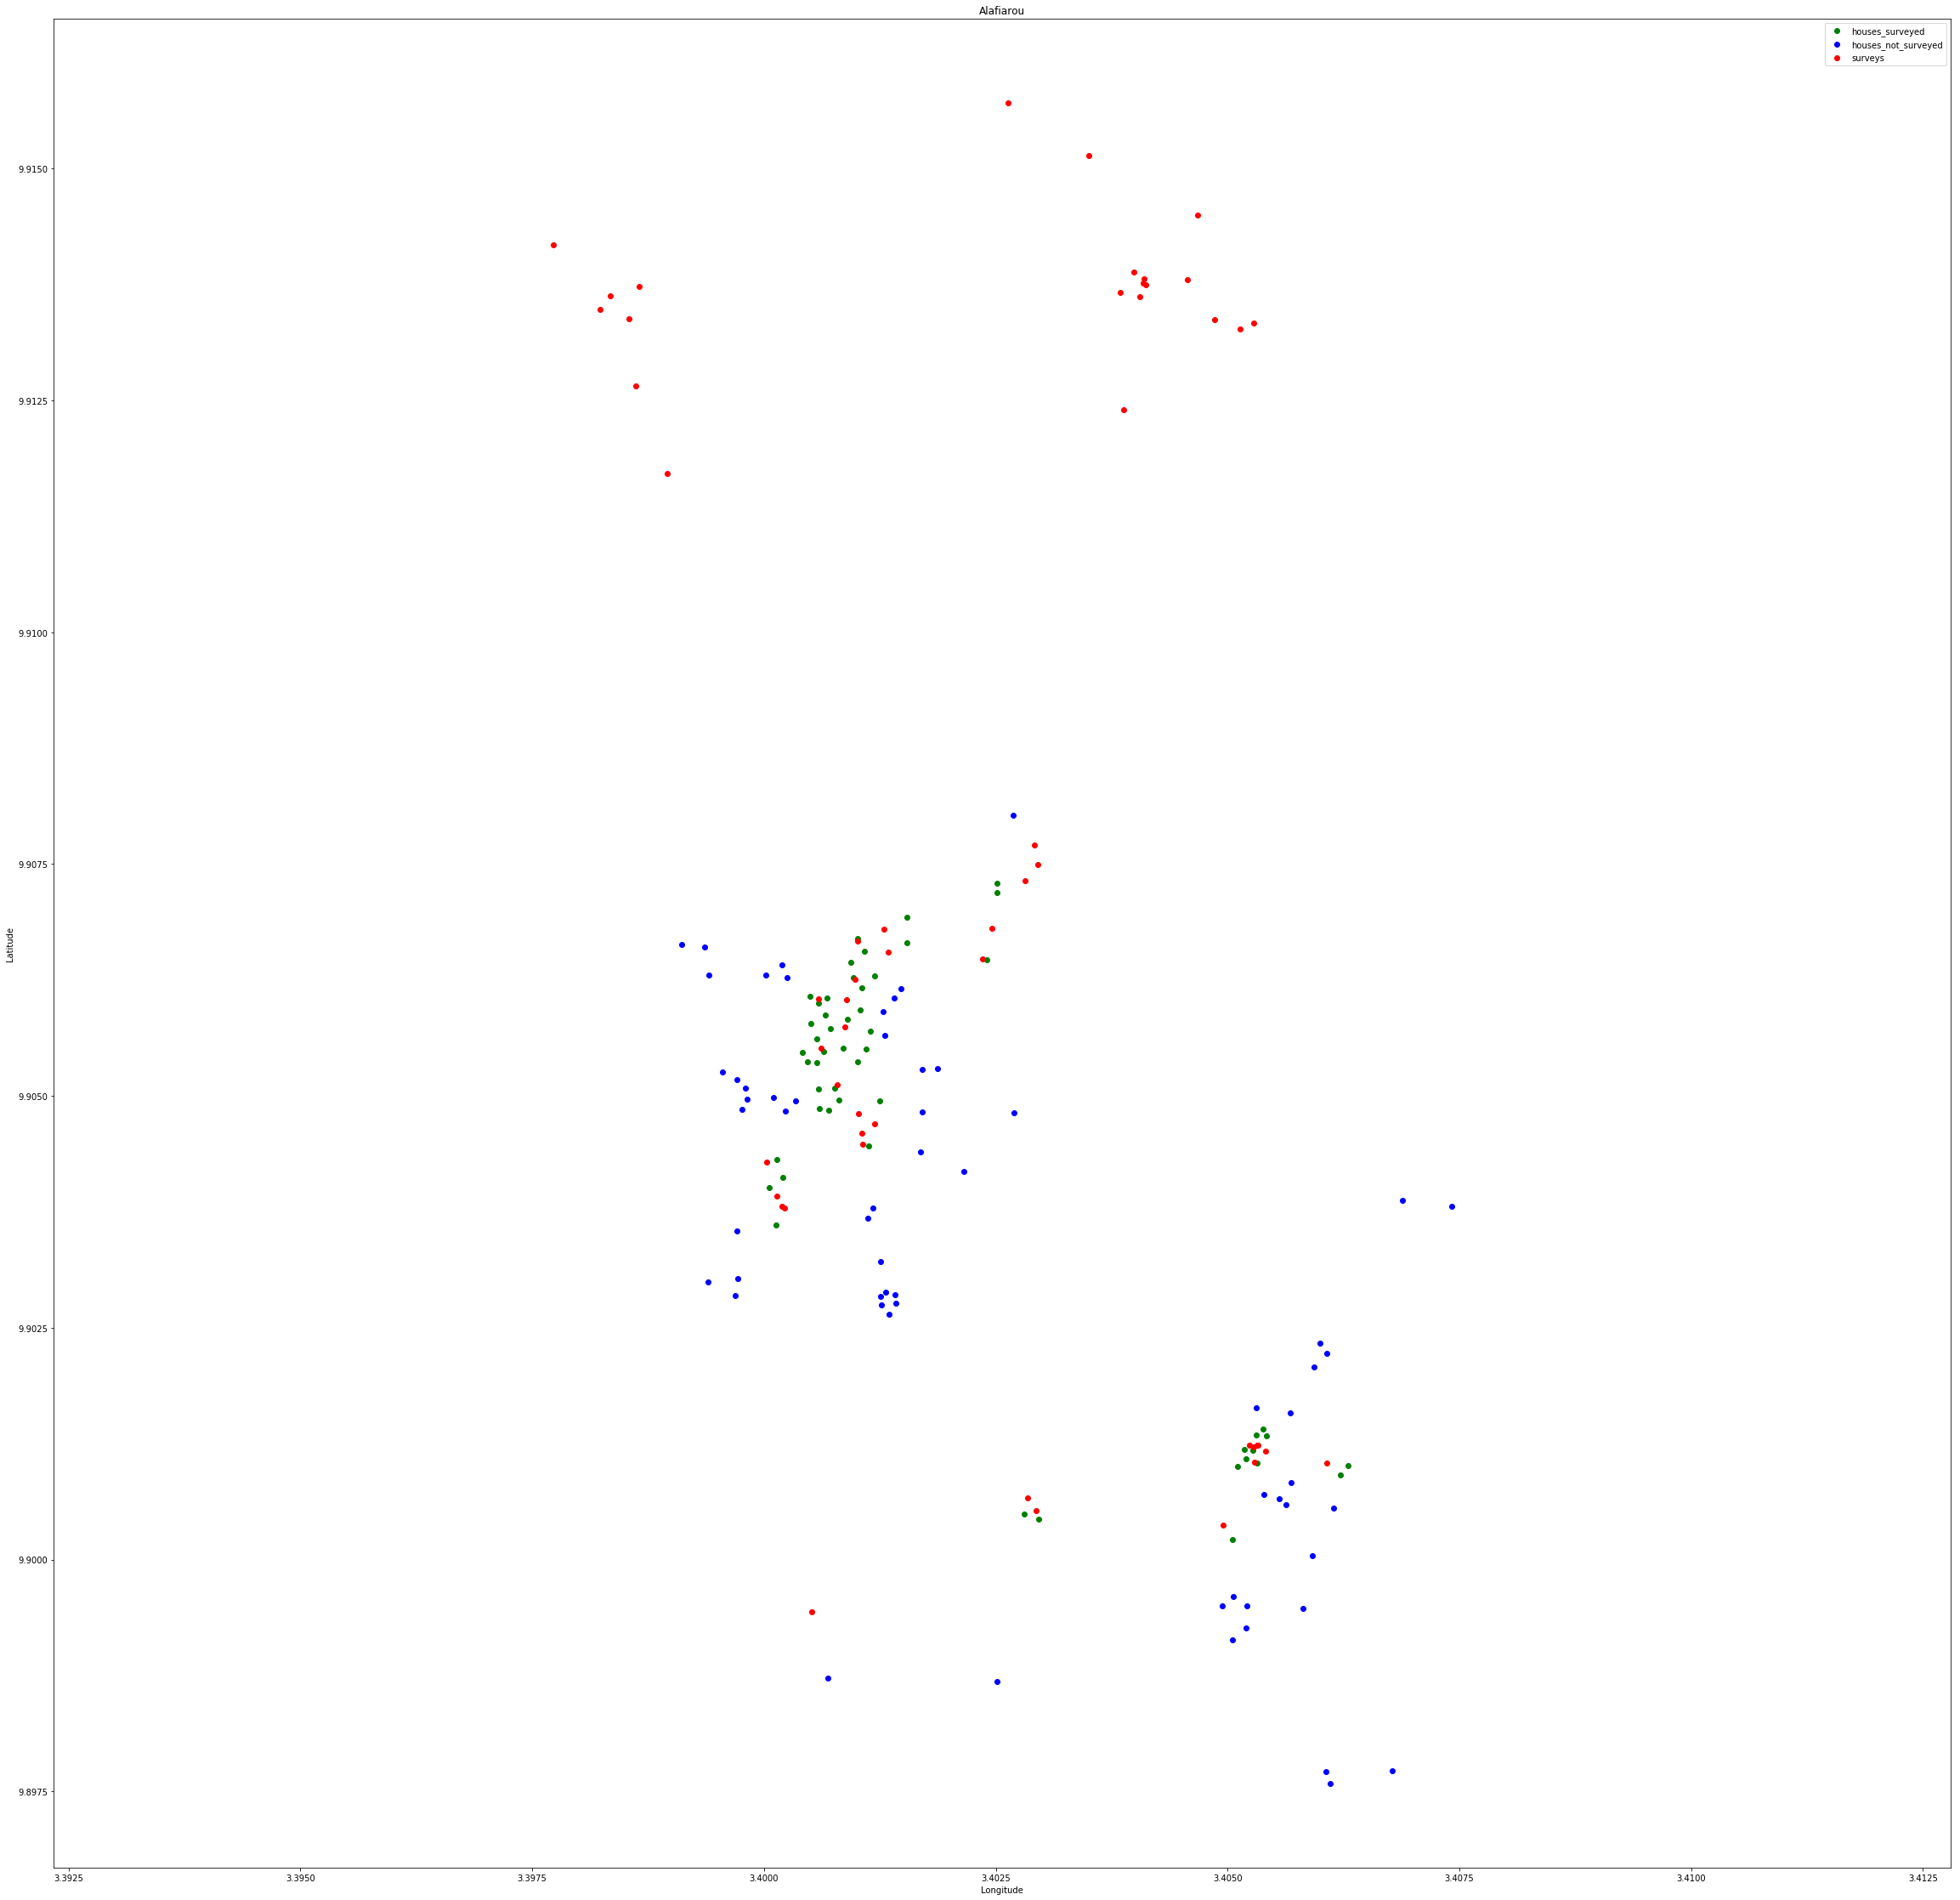

In [83]:

f,ax = plt.subplots(1,figsize=(40,40))
# Collect coords into list
coords = []

df_survey=df_houses[df_houses['surveyed']]
for a,b in zip(df_survey['lon'].to_list(),df_survey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='green',label='houses_surveyed')

coords = []
df_notsurvey=df_houses[~df_houses['surveyed']]
for a,b in zip(df_notsurvey['lon'].to_list(),df_notsurvey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='blue',label='houses_not_surveyed')

coords = []
df_debbo=df_priority[df_priority['village']==village]
for a,b in zip(df_debbo['longitude'].to_list(),df_debbo['latitude'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='red',label='surveys')


plt.title(village)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.legend()
plt.show()

# ESTIMACION DE LA POBLACION

In [60]:
def n_houses(x):
    p_1={'lat':x['latitude'],'lon':x['longitude']}
    points=df_houses.apply(lambda x: True
                             if distance(p_1,{'lat':x['lat'],'lon':x['lon']}) <40
                             else False
                                        ,axis=1)
    return points.sum()

In [85]:
df_priority['n_houses']=df_priority.apply(lambda x: n_houses(x),axis=1)

In [86]:
n_houses_surveyed=df_priority['n_houses'].sum()
n_houses_surveyed

132

In [87]:
n_people_belonging_to_houses=df_priority[df_priority['n_houses']!=0]['nb_people'].sum()
n_people_belonging_to_houses

388

In [88]:
n_total_houses=len(df_houses)
n_total_houses

114

In [89]:
#population estimate
n_people_belonging_to_houses*n_total_houses/n_houses_surveyed

335.09090909090907

In [90]:
#population in regards to survey
df_village[df_village['village_name']==village]['village_pop']

7    400
Name: village_pop, dtype: object

## FOR ALL DATA

In [63]:
village_translate={
    'Alafiarou':'ALAFIAROU',
    'Sonkorou':'SONKOROU',
    'Kora seko Kparou où Sansi Gah Gourou':'KORA SEKO KPAROU - SANSI GAH GOUNOU',
    'Debbo':'DEBBO',
    'Danon':'DANON Gando',
    'Gbérou kpanin':'GBÉROU KPANIN',
    'Wodora':'WODORA',
    'Tata Lafiarou ou Djonwouro Kparou ':'DJONWOURA KPAROU',
    'Gnankpare':'GNANKPARE',
    'Bio Sika Kparou ':'BIO SIKA KPAROU',
    'Chein Gbérou Kpanin':'GAH SONA'
    
}

In [64]:
villages=[vil for vil in df_priority.village.unique()]
pop_est={}
vil_house_data={}
for vil in villages:
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = ("""
    [out:json];
    area['name'='"""+village_translate[vil]+
    """']->.a;
    way[building](area.a);
    (._;>;);
    out body;
    """)

    response = requests.get(overpass_url, 
                            params={'data': overpass_query})

    data = response.json()
    houses = []
    
    ways=[elem for elem in data['elements']  if elem['type']=='way']
    nodes=[elem for elem in data['elements']  if elem['type']=='node']
    
    for way in ways:
        houses_info={}
        houses_info['id']=way['id']
        nodes_lats=[]
        nodes_longs=[]
        houses_info['nodes']=way['nodes']
        for node in nodes:
            if node['id'] in houses_info['nodes']:
                nodes_lats.append(node['lat'])
                nodes_longs.append(node['lon'])
        houses_info['lat']=np.mean(np.array(nodes_lats))
        houses_info['lon']=np.mean(np.array(nodes_longs))
        houses.append(houses_info)
        
    df_houses=pd.DataFrame(houses)
    
    print(vil,len(df_houses))
    df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)
    df_priority['n_houses']=df_priority.apply(lambda x: n_houses(x),axis=1)
    df_vil=df_priority[df_priority['village']==vil]
    n_houses_surveyed=df_vil['n_houses'].sum()
    n_people_belonging_to_houses=df_vil[df_vil['n_houses']!=0]['nb_people'].sum()
    n_total_houses=len(df_houses)
    pop_est[vil]=n_people_belonging_to_houses*n_total_houses/n_houses_surveyed
    vil_house_data[vil]=df_houses.to_dict()

Alafiarou 114
Debbo 37
Sonkorou 22
Danon 55
Tata Lafiarou ou Djonwouro Kparou  6
Kora seko Kparou où Sansi Gah Gourou 65
Bio Sika Kparou  21
Gnankpare 18
Chein Gbérou Kpanin 25


In [71]:
df_vill_analy[['house_data','pop_est']]=df_vill_analy.apply(lambda x: pd.Series([
                                        vil_house_data[x['village']],
                                        pop_est[x['village']]
                                            ]),axis=1)

In [75]:
df_vil_final=pd.merge(df_village,df_vill_analy,left_on='village_name',right_on='village',how='outer')

## PUBLISH DATA TO BIGQUERY

In [116]:
import pandas_gbq
import unidecode

from google.cloud import bigquery
import os

In [117]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/Users/5danalfaro/OAN/credentials/OAN Gestion Eau-b067bbf8dde1.json'

In [118]:
client = bigquery.Client()

## create dataset

In [121]:
# TODO(developer): Set dataset_id to the ID of the dataset to create.
dataset_id = "{}.priority_data".format(client.project)

# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_id)

# TODO(developer): Specify thaae geographic location where the dataset should reside.
dataset.location = "EU"

In [72]:
# Send the dataset to the API for creation.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
dataset = client.create_dataset(dataset)  # API request
print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

Created dataset oan-gestion-eau.priority_data


In [122]:
"{}.{}".format(client.project, dataset.dataset_id)

'oan-gestion-eau.priority_data'

In [110]:
bq_tr_typ={'float64':'FLOAT64',
           'int64':'INT64',
           'datetime64[ns, UTC]':'DATETIME',
           'object':'STRING'}

## create table for priority survey

In [127]:
df_priority.columns = ['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l_per', 't_diar', 't_mal', 'village',
       'n_houses']

In [128]:
schema = [bigquery.SchemaField(ind,bq_tr_typ[str(typ)]) 
          for ind,typ in zip(df_priority.dtypes.index.to_list(),df_priority.dtypes.to_list())]

In [129]:
# TODO(developer): Construct a BigQuery client object.
# client = bigquery.Client()

# TODO(developer): Set table_id to the ID of the table to create
table_id = "{}.{}.priority_surveys".format(client.project, dataset.dataset_id)

table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # API request
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table oan-gestion-eau.priority_data.priority_surveys


In [131]:
table_id_pd = "{}.priority_surveys".format(dataset.dataset_id)

In [132]:
pandas_gbq.to_gbq(df_priority, table_id_pd, project_id=client.project, if_exists='replace')

1it [00:13, 13.76s/it]


## create table for village info

In [135]:
df_vil_final.columns = ['village_coords', 'creation_date', 'nb_water_sources', 'heath_center',
       'village_pop', 'village_name', 'water_sources', 'longitude', 'latitude',
       'perc_s_potable', 'village', 'nb_people', 'nb_diarrhoea', 'nb_malnu',
       'nb_basin', 'water_quality', 'self_manag', 'n_enquetes', 'l_per',
       't_diar', 't_mal', 'house_data', 'pop_est']

In [141]:
df_vil_final_to_up=df_vil_final[['creation_date', 'nb_water_sources', 'heath_center',
       'village_pop', 'village_name', 'water_sources', 'longitude', 'latitude',
       'perc_s_potable', 'nb_people', 'water_quality', 'self_manag', 'n_enquetes', 'l_per',
       't_diar', 't_mal', 'pop_est']].copy()

In [146]:
df_vil_final_to_up.longitude = pd.to_numeric(df_vil_final_to_up.longitude,errors='coerce')
df_vil_final_to_up.latitude = pd.to_numeric(df_vil_final_to_up.latitude,errors='coerce')
df_vil_final_to_up.creation_date = pd.to_datetime(df_vil_final_to_up.creation_date)
df_vil_final_to_up.nb_water_sources = pd.to_numeric(df_vil_final_to_up.nb_water_sources,errors='coerce')

df_vil_final_to_up.heath_center = df_vil_final_to_up.heath_center.astype(str)

df_vil_final_to_up.village_pop = pd.to_numeric(df_vil_final_to_up.village_pop,errors='coerce')

df_vil_final_to_up.village_name = df_vil_final_to_up.village_name.astype(str)
df_vil_final_to_up.perc_s_potable = pd.to_numeric(df_vil_final_to_up.perc_s_potable,errors='coerce')

df_vil_final_to_up.nb_people = pd.to_numeric(df_vil_final_to_up.nb_people,errors='coerce')

df_vil_final_to_up.water_quality = pd.to_numeric(df_vil_final_to_up.water_quality,errors='coerce')

df_vil_final_to_up.self_manag = pd.to_numeric(df_vil_final_to_up.self_manag,errors='coerce')


df_vil_final_to_up.n_enquetes = pd.to_numeric(df_vil_final_to_up.n_enquetes,errors='coerce')



In [149]:
schema = [bigquery.SchemaField(ind,bq_tr_typ[str(typ)]) 
          for ind,typ in zip(df_vil_final_to_up.dtypes.index.to_list(),df_vil_final_to_up.dtypes.to_list())]


In [150]:
# TODO(developer): Construct a BigQuery client object.
# client = bigquery.Client()

# TODO(developer): Set table_id to the ID of the table to create
table_id = "{}.{}.village_data".format(client.project, dataset.dataset_id)

table = bigquery.Table(table_id, schema=schema)
table = client.create_table(table)  # API request
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table oan-gestion-eau.priority_data.village_data


In [151]:
table_id_pd = "{}.village_data".format(dataset.dataset_id)

In [152]:
pandas_gbq.to_gbq(df_vil_final_to_up, table_id_pd, project_id=client.project, if_exists='replace')

1it [00:12, 12.80s/it]


### FALCOM SQL CLIENT

#### connected to falcom to publish tables
<iframe width="900" height="800" frameborder="0" scrolling="no" src="//plot.ly/~5danalfaro/9.embed"></iframe>

In [155]:
client.project

'oan-gestion-eau'

In [156]:
table_id_pd

'priority_data.village_data'

### VISUALIZE DATA

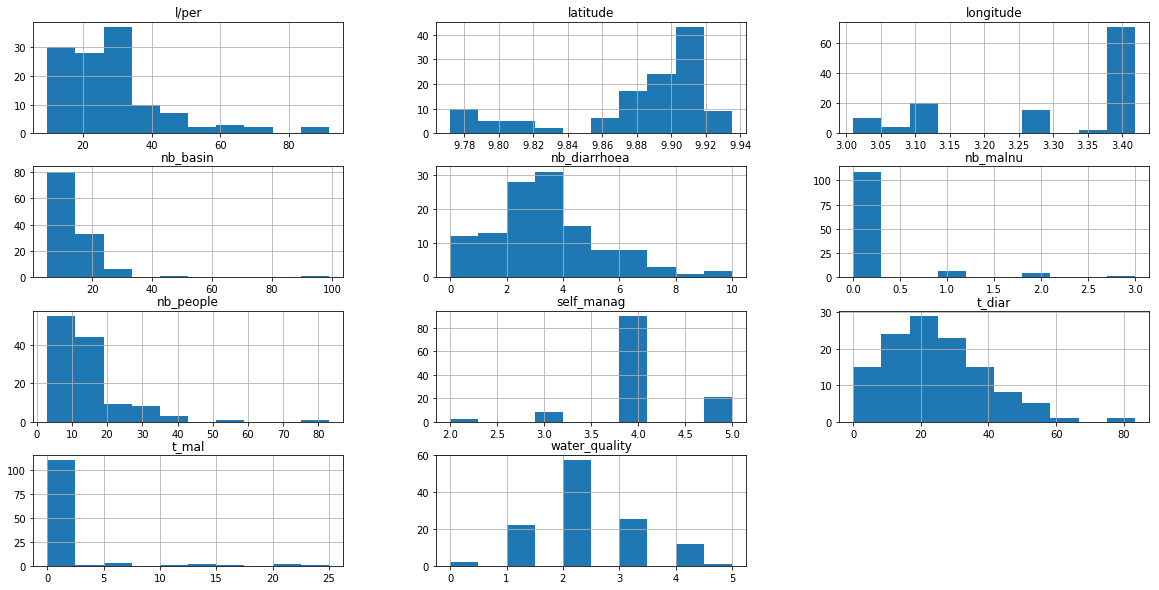

In [35]:
df_priority.hist(figsize=(20,10))
plt.show()

In [36]:
df_priority.columns

Index(['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l/per', 't_diar', 't_mal', 'village'],
      dtype='object')

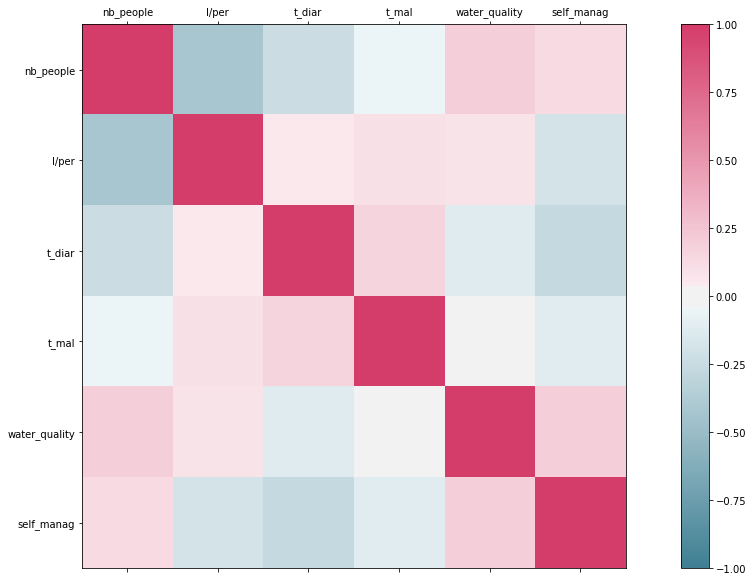

In [37]:
df_correlations = df_priority[['nb_people','l/per','t_diar',
                               't_mal','water_quality','self_manag']].copy()
names=df_correlations.columns
correlations = df_correlations.corr()
# plot correlation matrix
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, cmap=sns.diverging_palette(220, 0, as_cmap=True), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [38]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

,nb_people,l/per,t_diar,t_mal,water_quality,self_manag
nb_people,1,-0.42,-0.23,-0.053,0.19,0.13
l/per,-0.42,1,0.054,0.096,0.083,-0.18
t_diar,-0.23,0.054,1,0.16,-0.12,-0.26
t_mal,-0.053,0.096,0.16,1,0.011,-0.11
water_quality,0.19,0.083,-0.12,0.011,1,0.19
self_manag,0.13,-0.18,-0.26,-0.11,0.19,1


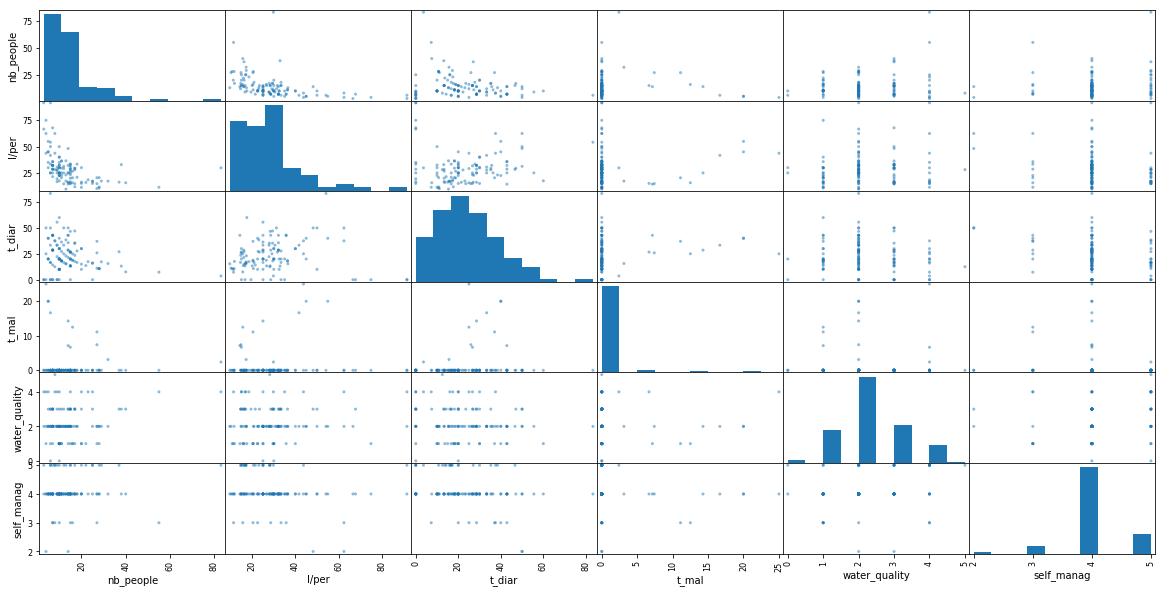

In [39]:
scatter_matrix(df_correlations,figsize=(20,10))
plt.show()

In [45]:
df_priority.columns

Index(['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l/per', 't_diar', 't_mal', 'village'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


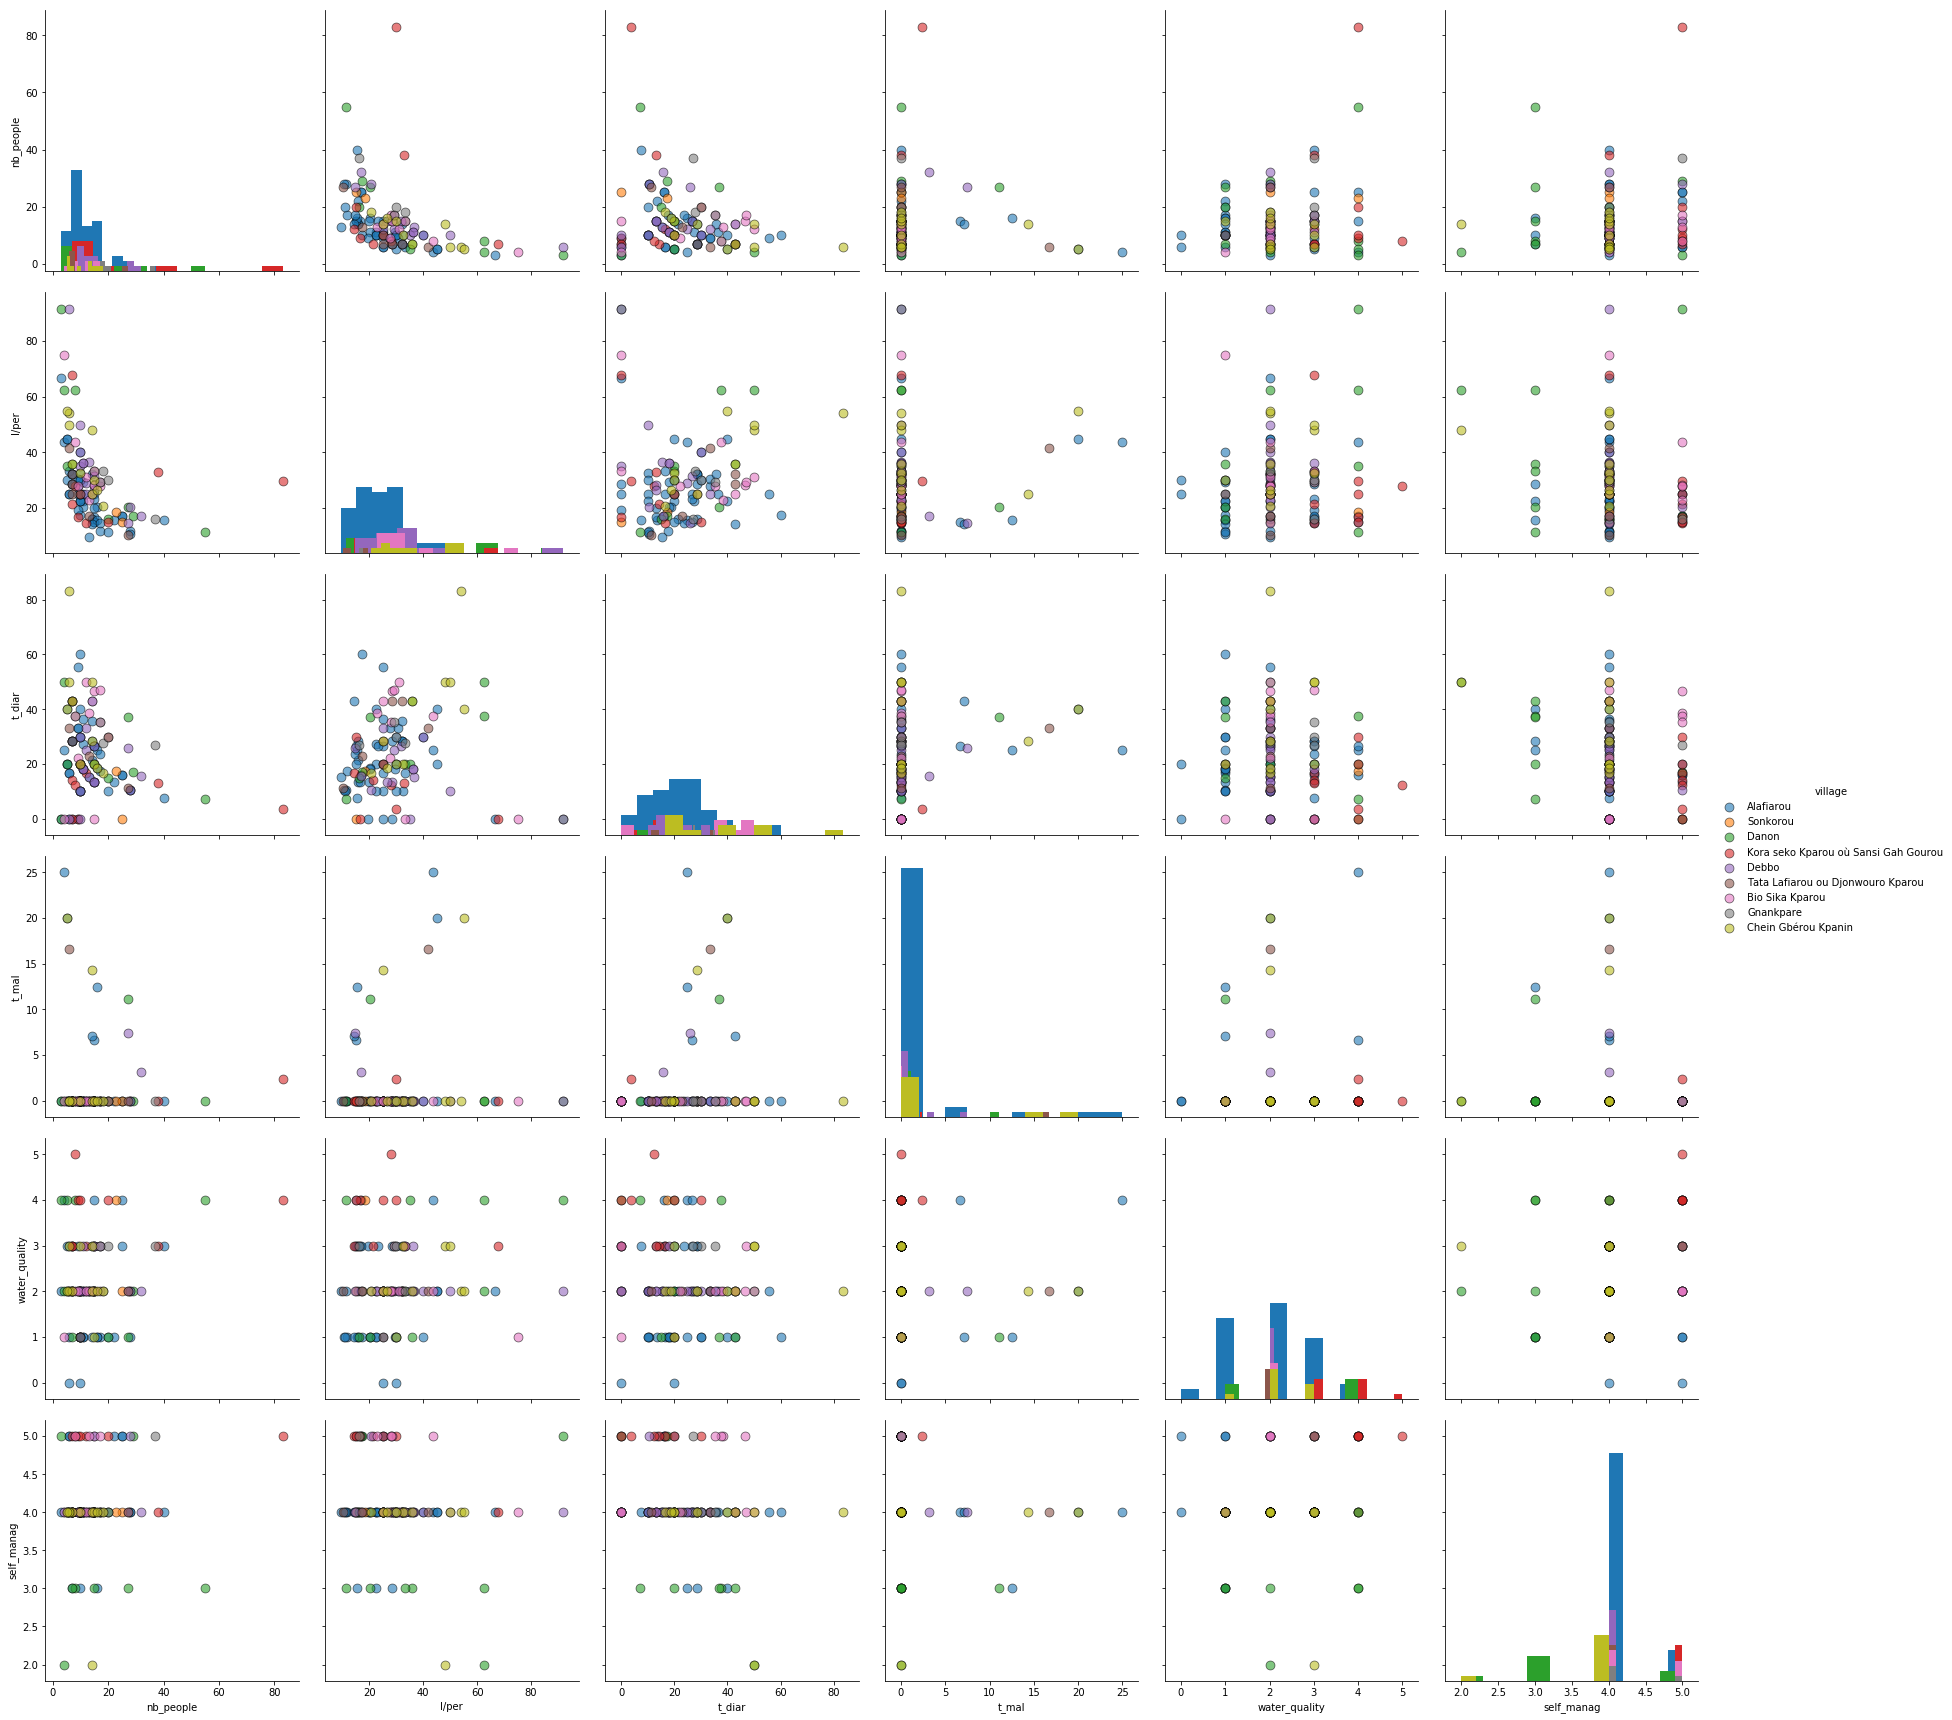

In [48]:
df_correlations = df_priority[['village','nb_people','l/per','t_diar',
                               't_mal','water_quality','self_manag']].copy()

sns.pairplot(df_correlations, hue = 'village', diag_kind = 'hist',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)
plt.show()

## RELATION BETWEEN DIARREAH AND l/per

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


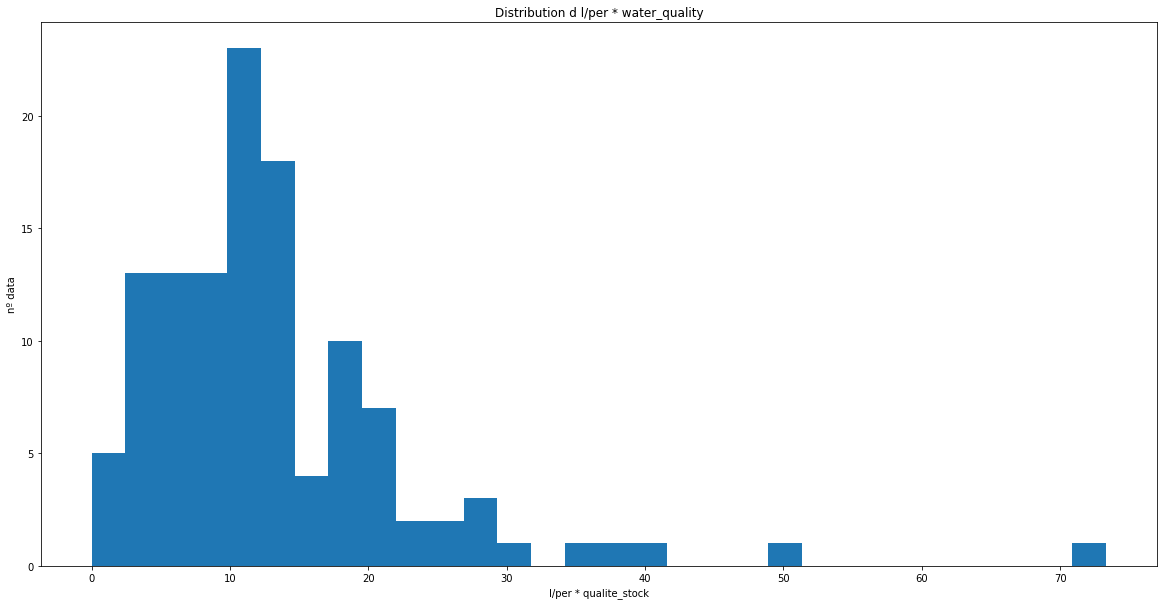

In [40]:
f, ax = plt.subplots(1, figsize=(20,10))

x=df_priority['l/per']*(df_priority['water_quality']/5)

ax.hist(x,bins=30)

ax.set_xlabel('l/per * qualite_stock')

ax.set_ylabel('nº data')

ax.set_title("Distribution d l/per * water_quality")

plt.show()

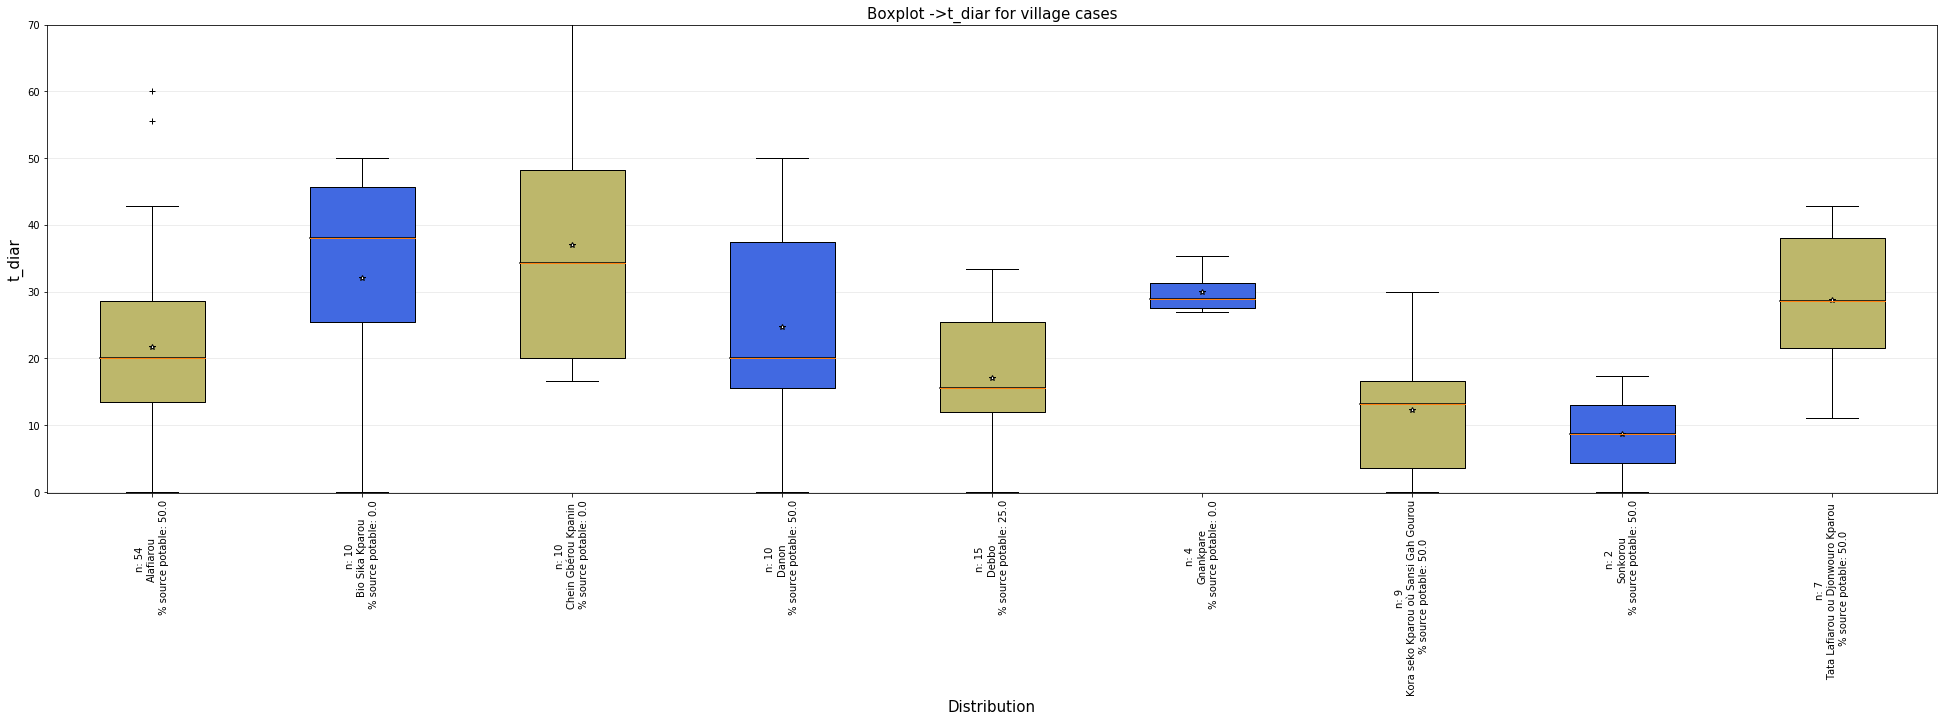

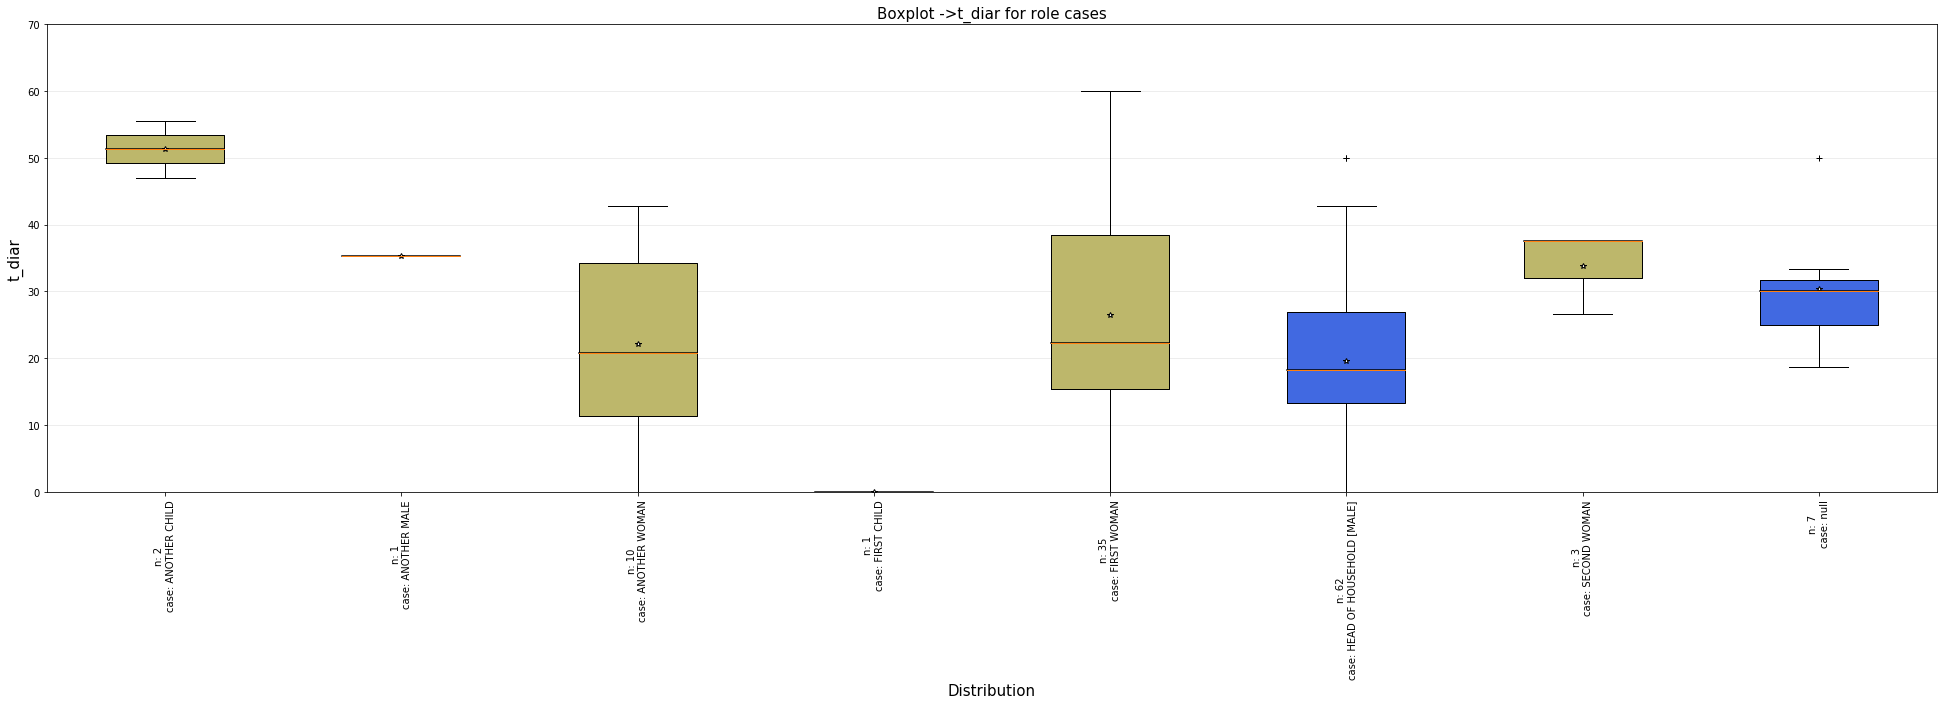

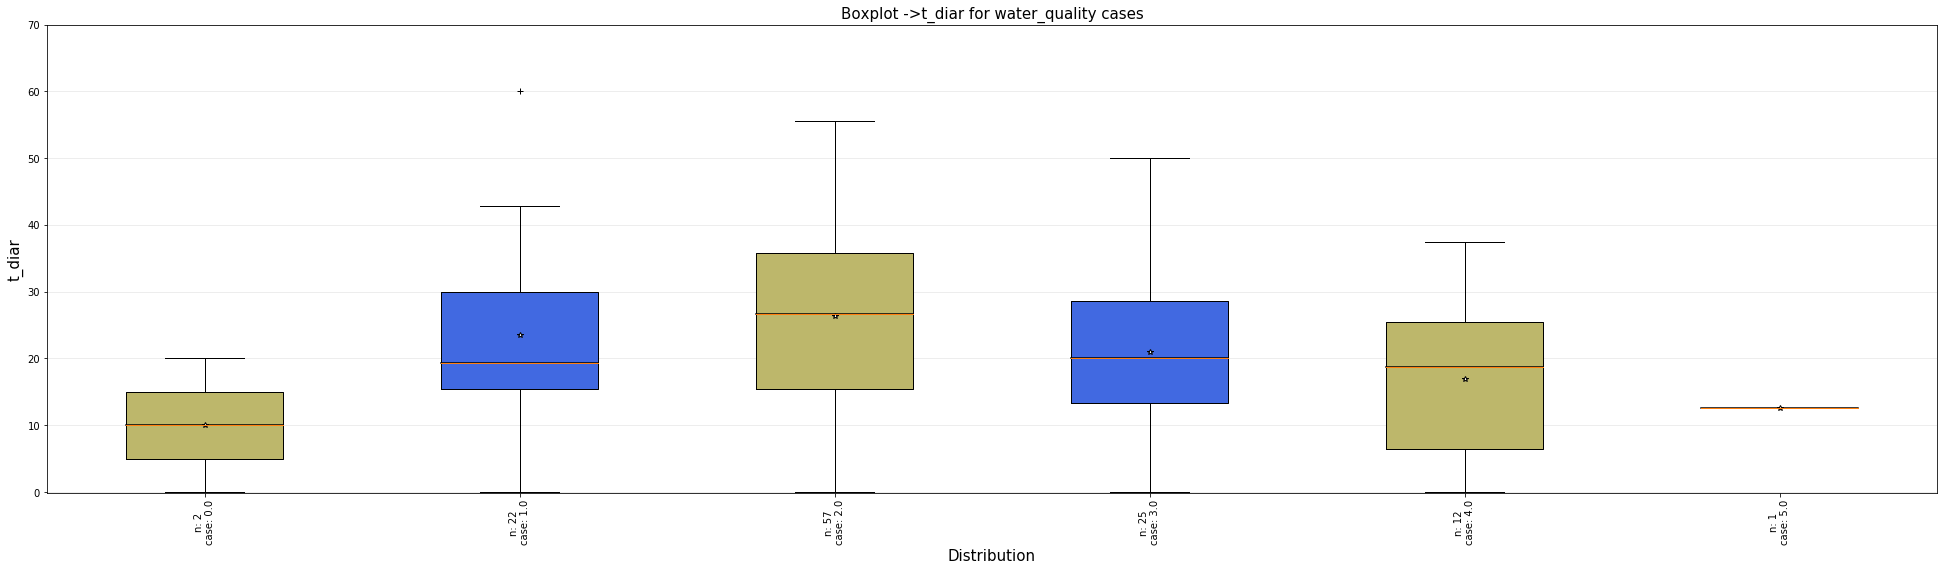

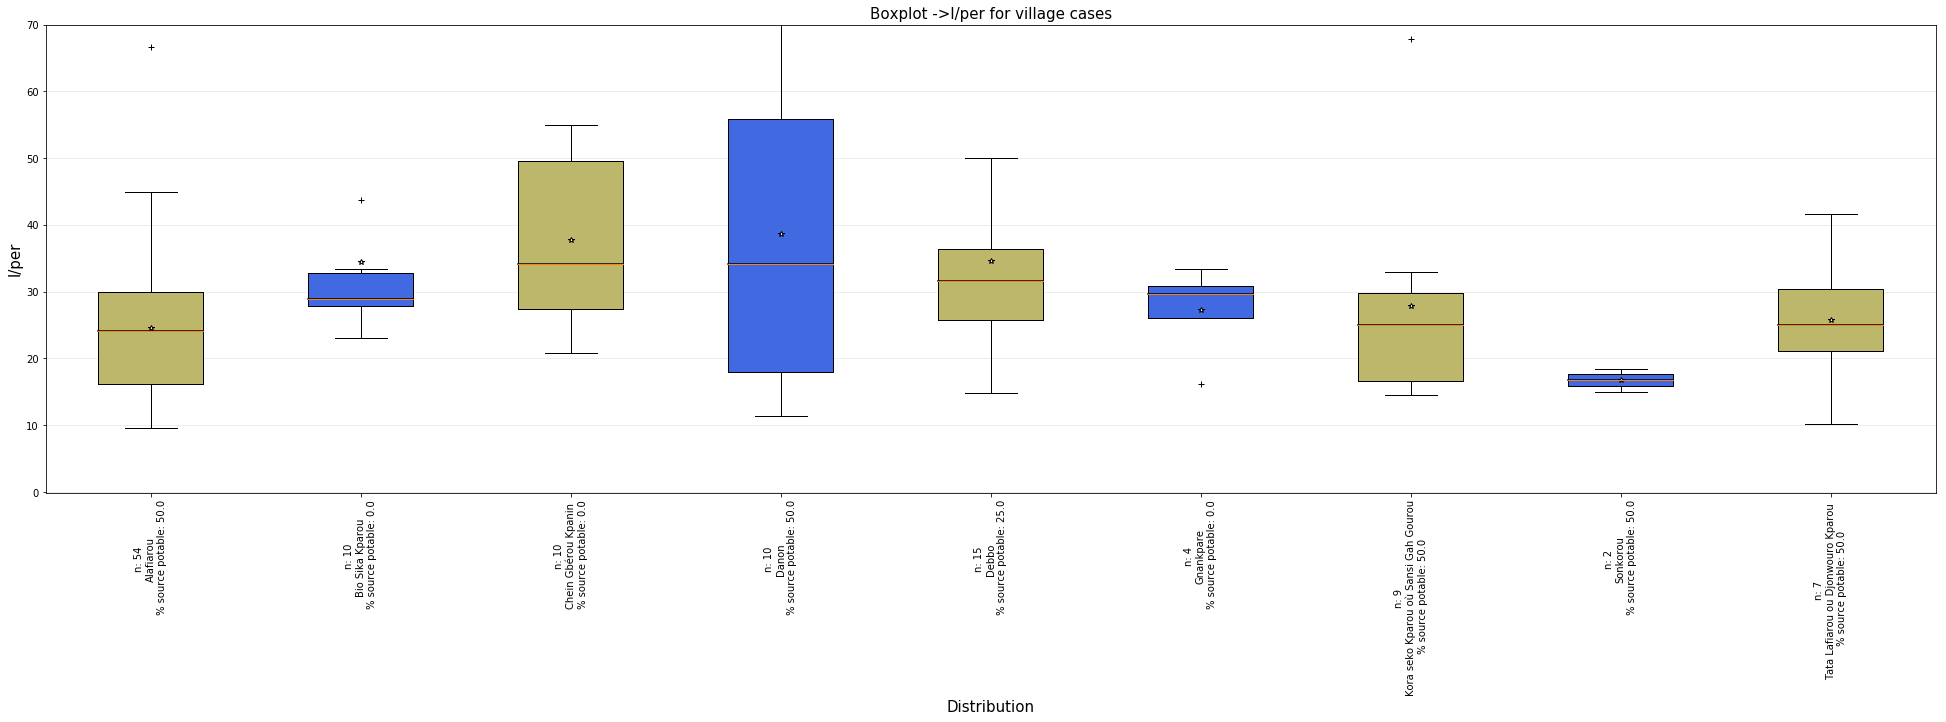

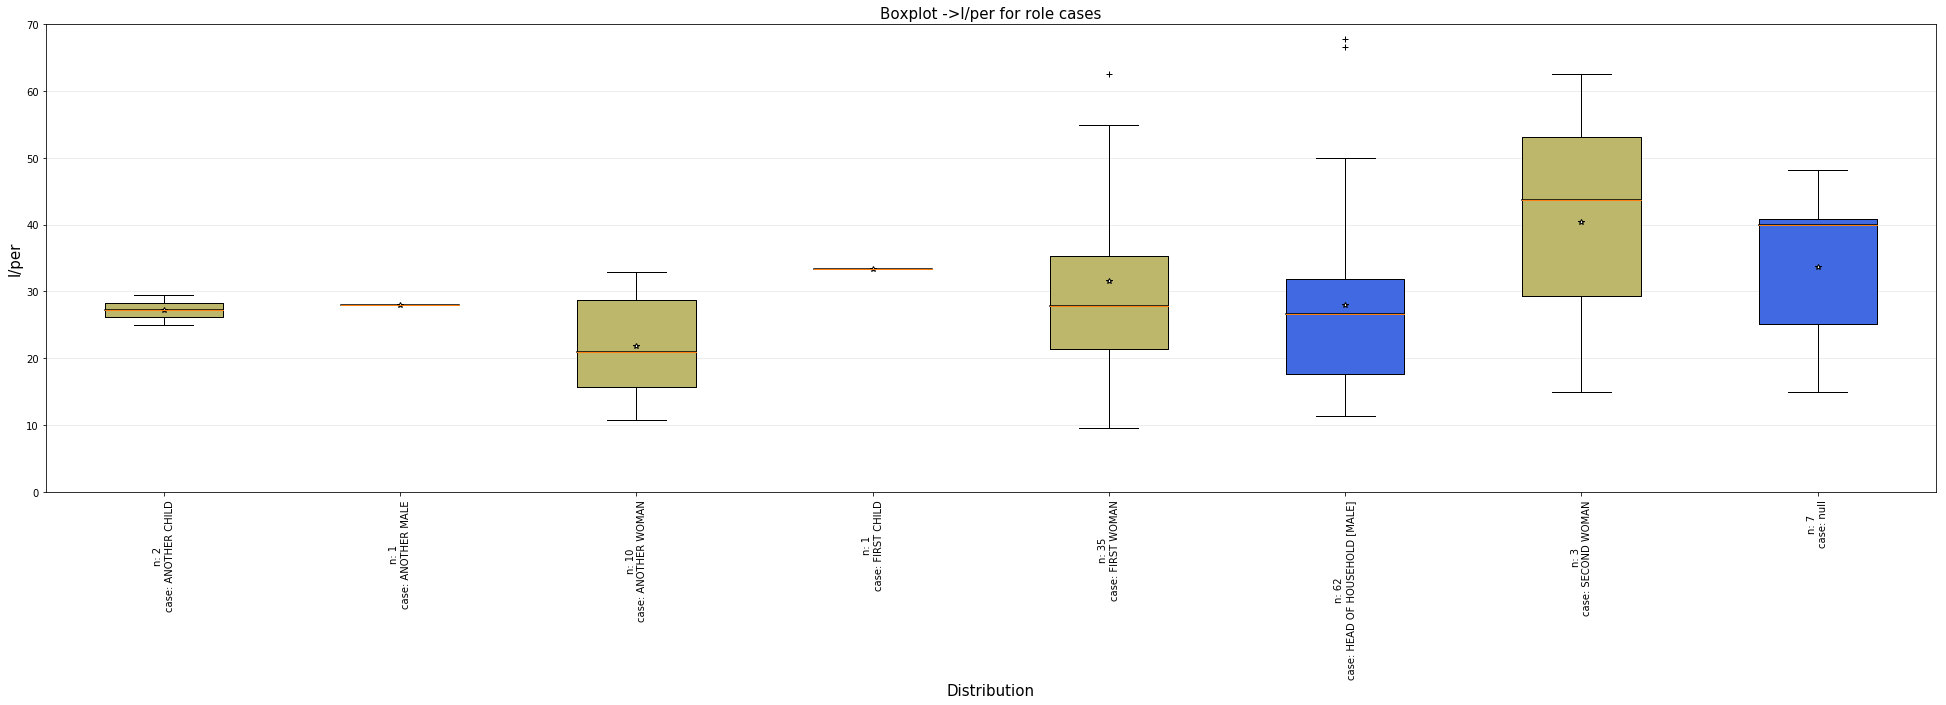

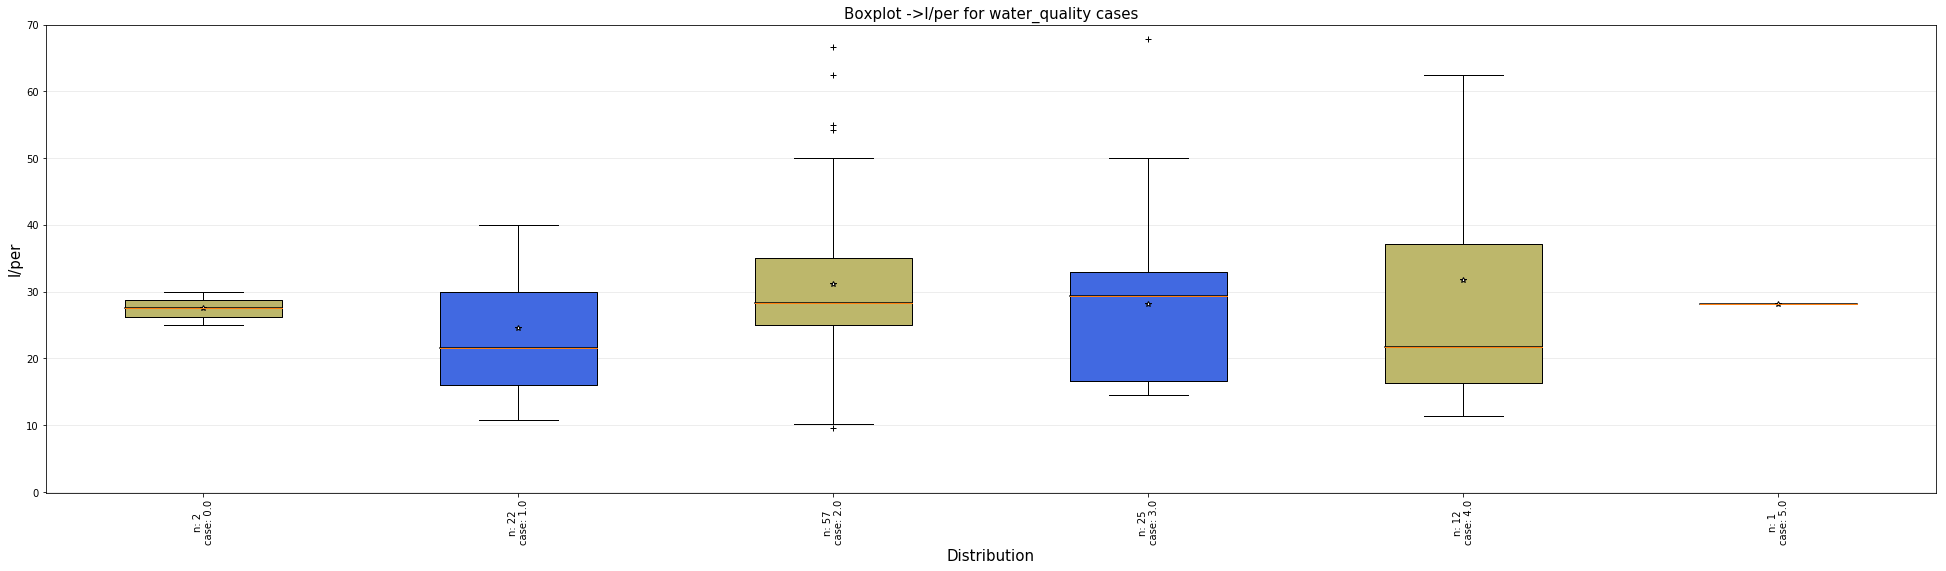

In [55]:
z=2

datas_to_filter=['village','role','water_quality']
values_to_show=['t_diar','l/per']
for value in values_to_show:
    for data_to_filter in datas_to_filter:
        cases=df_priority[data_to_filter].sort_values().dropna().unique()
        #wat_qual=df_priority['role'].sort_values().dropna().unique()
        data = [df_priority[df_priority[data_to_filter]==a][value] for a in cases]
        data_size= [len(a) for a in data]
        if data_to_filter == 'village':
            labels = ['n: '+str(data_siz)+'\n'+str(case)+'\n % source potable: '+str(df_village[df_village['village_name']==case]['%_s_potable'].values[0])
                      for data_siz,case in zip(data_size,cases)]
        else:
             labels = ['n: '+str(data_siz)+'\ncase: '+str(case)
                      for data_siz,case in zip(data_size,cases)]
        fig, ax1 = plt.subplots(figsize=(30, 10))
        #fig, ax1 = plt.subplots(figsize=(10, 6))

        fig.canvas.set_window_title('A Boxplot Example')
        fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

        bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
        plt.setp(bp['boxes'], color='black')
        plt.setp(bp['whiskers'], color='black')
        plt.setp(bp['fliers'], color='red', marker='+')

        # Add a horizontal grid to the plot, but make it very light in color
        # so we can use it for reading data values but not be distracting
        ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                       alpha=0.5)

        # Hide these grid behind plot objects
        ax1.set_axisbelow(True)
        ax1.set_title('Boxplot ->'+value+' for '+data_to_filter + ' cases',fontsize=15)
        ax1.set_xlabel('Distribution',fontsize=15)
        ax1.set_ylabel(value,fontsize=15)


        # Now fill the boxes with desired colors
        boxColors = ['darkkhaki', 'royalblue']
        numBoxes = len(cases)
        medians = list(range(numBoxes))
        for i in range(numBoxes):
            box = bp['boxes'][i]
            boxX = []
            boxY = []
            for j in range(5):
                boxX.append(box.get_xdata()[j])
                boxY.append(box.get_ydata()[j])
            boxCoords = np.column_stack([boxX, boxY])
            # Alternate between Dark Khaki and Royal Blue
            k = i % 2
            boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
            ax1.add_patch(boxPolygon)
            # Now draw the median lines back over what we just filled in
            med = bp['medians'][i]
            medianX = []
            medianY = []
            for j in range(2):
                medianX.append(med.get_xdata()[j])
                medianY.append(med.get_ydata()[j])
                ax1.plot(medianX, medianY, 'k')
                medians[i] = medianY[0]
            # Finally, overplot the sample averages, with horizontal alignment
            # in the center of each box
            ax1.plot([np.average(med.get_xdata())], [np.average(data[i])],
                     color='w', marker='*', markeredgecolor='k')

        # Set the axes ranges and axes labels
        ax1.set_xlim(0.5, numBoxes + 0.5)
        top = 70
        bottom = -70
        ax1.set_ylim(-0.1, top)
        ax1.set_xticklabels(labels,
                            rotation=90, fontsize=10)
        #ax1.set_xticklabels(list(csvData[z].index),
                            #rotation=45, fontsize=8)

        plt.show()

### to export to plotly

In [41]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

In [42]:
df_priority.pivot_table(values='l/per',columns='village')

village,Alafiarou,Bio Sika Kparou,Chein Gbérou Kpanin,Danon,Debbo,Gnankpare,Kora seko Kparou où Sansi Gah Gourou,Sonkorou,Tata Lafiarou ou Djonwouro Kparou
l/per,24.630128,34.487431,37.799107,38.593967,34.620251,27.240329,27.930525,16.73913,25.696261


In [43]:
import os
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output


### dash with selection for village and diarhea

In [46]:
df = df_priority
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

if 'DYNO' in os.environ:
    app_name = os.environ['DASH_APP_NAME']
else:
    app_name = 'dash-boxplot'

app.layout = html.Div([html.Div([
        html.H1("Taux de diarhee selon village")], style={"textAlign": "center"}),
        dcc.Graph(id="my-graph"),
        html.Div([dcc.RangeSlider(id="selected-qualite",min=0,max=5,
                 marks={0: "0", 1: "1", 2: "2", 3: "3",4: "4",5: "5",},value=[0, 2],)],
                 style={"display": "block","margin-left": "auto","margin-right": "auto","width": "60%"}),
], className="container")


@app.callback(
    Output('my-graph', 'figure'),
    [Input('selected-qualite', 'value')])
def update_figure(selected):
    dff = df[(df["water_quality"] >= selected[0]) & (df["water_quality"] <= selected[1])]
    traces = []
    for vil in dff.village.unique():
        traces.append(go.Box(y=dff[dff["village"] == vil]["t_diar"],name=vil,marker={"size": 4}))
    return {"data": traces,
            "layout": go.Layout(title=f"Taux de diarrhee selon qualité{'-'.join(str(i) for i in selected)}",autosize=True,
                                margin={"l": 200, "b": 100, "r": 200},xaxis={"showticklabels": False,},
                                yaxis={"title": f"t_diar",},)}


#### dash for role that reply

In [65]:
df = df_priority
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

if 'DYNO' in os.environ:
    app_name = os.environ['DASH_APP_NAME']
else:
    app_name = 'dash-boxplot'
    
#options for radioitems
all_options=df_priority.village.unique()

app.layout = html.Div([html.Div([
        html.H1("Taux de diarhee selon village")], style={"textAlign": "center"}),
        dcc.Graph(id="my-graph"),
        html.Div([
            
               dcc.RadioItems(
                id='selected-role',
                options=[{'label': k, 'value': k} for k in all_options],
                value=all_options[0]
    ),
        ],
                 style={"display": "block","margin-left": "auto","margin-right": "auto","width": "60%"}
        ),
], className="container")


@app.callback(
    Output('my-graph', 'figure'),
    [Input('selected-role', 'value')])
def update_figure(selected):
    dff = df[df["village"] == selected]
    traces = []
    for rol in dff.role.unique():
        traces.append(go.Box(y=dff[dff["role"] == rol]["t_diar"],name=rol,marker={"size": 4}))
    return {"data": traces,
            "layout": go.Layout(
                title=f"Taux de diarrhee selon roles dans village "+selected+'\n\n n= '+str(len(dff)),
                margin={"l": 200, "b": 100, "r": 200},xaxis={"showticklabels": False,},
                yaxis={"title": f"t_diar",},
            )
           }


In [66]:
app.run_server(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [10/Nov/2019 01:20:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2019 01:20:42] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2019 01:20:42] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2019 01:20:43] "POST /_dash-update-component HTTP/1.1" 200 -


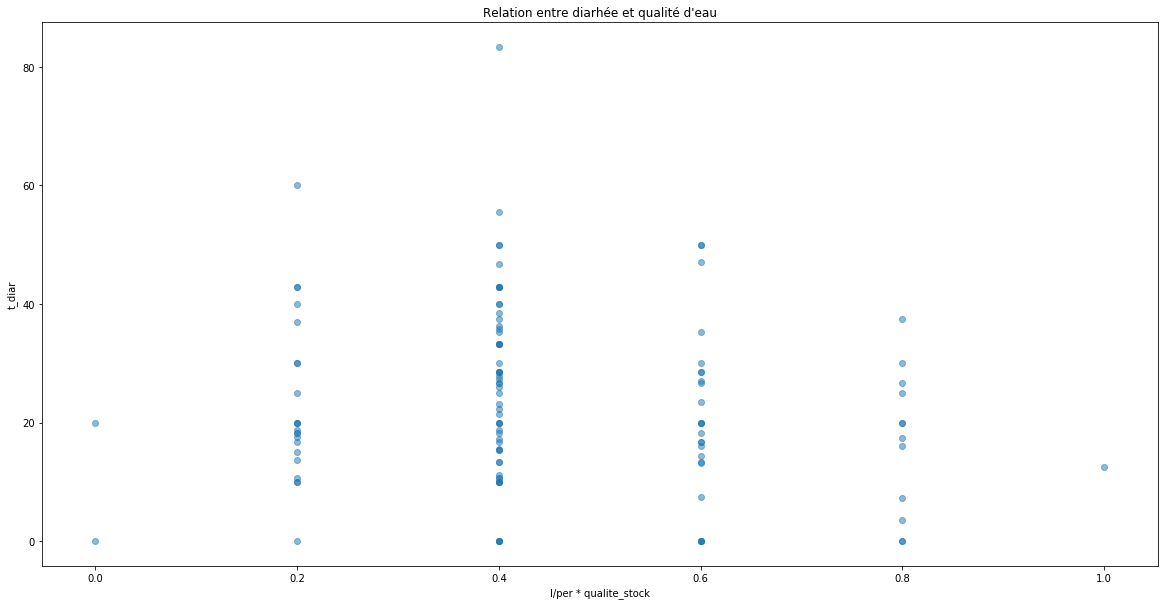

In [68]:
f, ax = plt.subplots(1, figsize=(20,10))

#x=df_priority['l/per']*(df_priority['water_quality']/5)

wat_qual=df_priority['water_quality'].sort_values().dropna().unique()
x=df_priority['water_quality']/5
y=df_priority['t_diar']

ax.scatter(x,y,alpha=0.5)

ax.set_xlabel('l/per * qualite_stock')

ax.set_ylabel('t_diar')

ax.set_title("Relation entre diarhée et qualité d'eau")

plt.show()

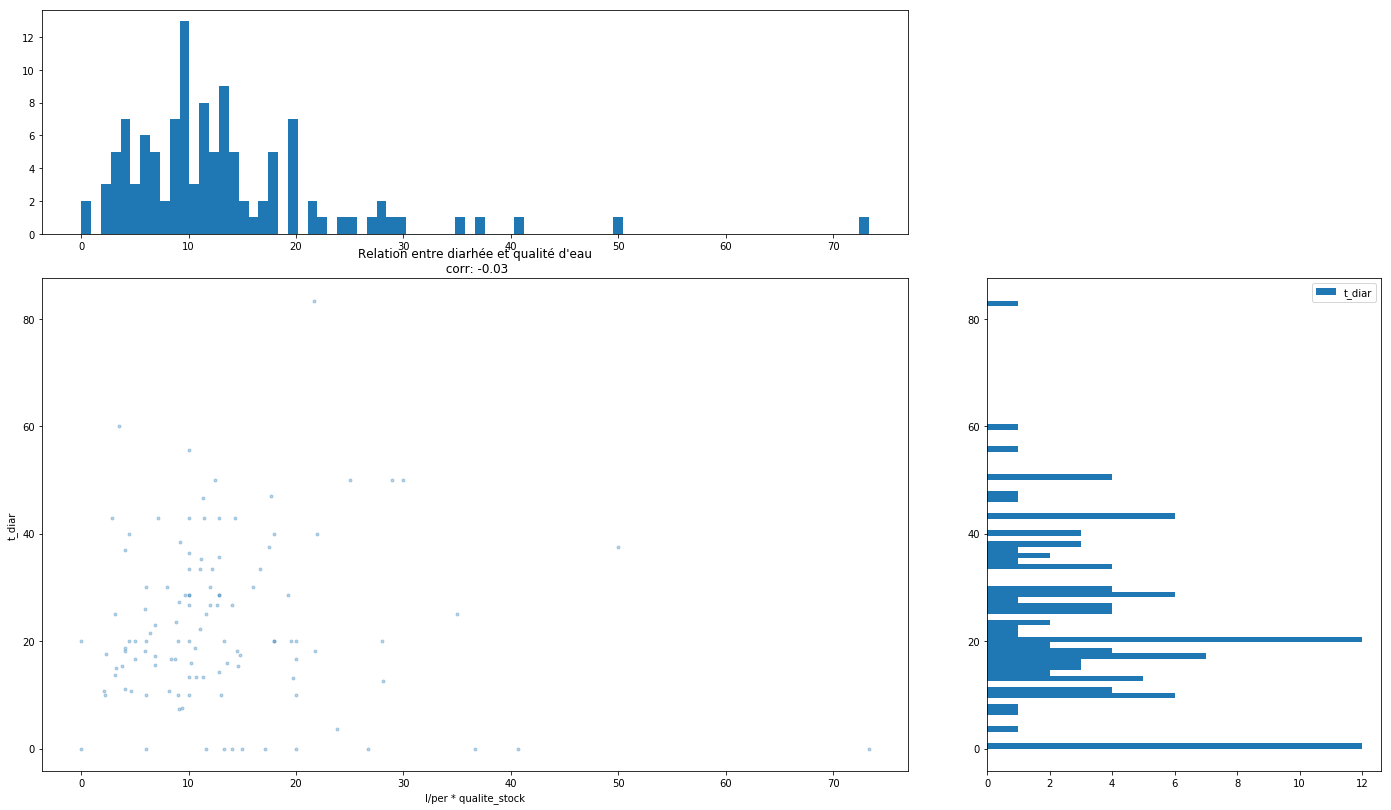

In [258]:
 # Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

df_plot=df_priority[(df_priority['l/per'].notnull()) &
         (df_priority['water_quality'].notnull()) &
         (df_priority['t_diar'].notnull())]

x=df_plot['l/per']*(df_plot['water_quality']/5)
#x=df_plot['water_quality']
y=df_plot['t_diar']

total_x, total_y = (np.array(x),np.array(y))

R2 = str(round(np.corrcoef(total_x, total_y)[1][0],2))

#scatter of variation in score and coverage relative variation and their histogram
scatter_axes = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
pyplot.title("Relation entre diarhée et qualité d'eau"+ "\n corr: " + R2)
pyplot.rcParams["figure.figsize"] = [24,14]
pyplot.xlabel("l/per * qualite_stock")
#pyplot.xlabel("qualite_stock")
pyplot.ylabel("t_diar")


x_hist_axes = plt.subplot2grid((3, 3), (0, 0), colspan=2,
                       sharex=scatter_axes)
y_hist_axes = plt.subplot2grid((3, 3), (1, 2), rowspan=2,
                       sharey=scatter_axes)

scatter_axes.plot(x, y, '.',alpha=0.3)
x_hist_axes.hist(x,bins=80)

y_hist_axes.hist(y, orientation='horizontal',bins=80)

pyplot.legend()
pyplot.show()

## DETERMINAR N MUESTRAL

<a href="https://towardsdatascience.com/how-to-use-python-to-figure-out-sample-sizes-for-your-study-871f0a76a19c">SOURCE</a>

In [116]:
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [117]:
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [138]:
p_diffs = [x*.01 for x in range(10,40)]

data = []
for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial probability'] = '20%'
    data.append(record)

for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.01)
    record['Confidence Level'] = '99%'
    record['Initial probability'] = '20%'
    data.append(record)

df = pd.DataFrame(data)

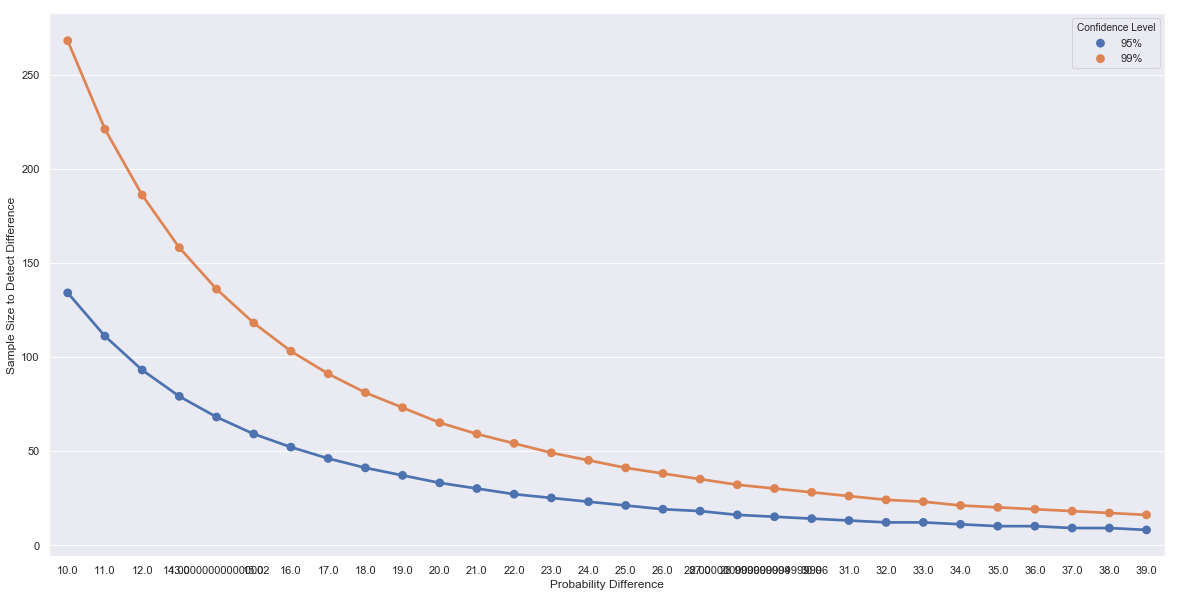

In [142]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(20, 10))

sns.set(style='darkgrid')

plot = sns.pointplot(x='Probability Difference',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)